<a href="https://colab.research.google.com/github/jrosalesj/Evaluacion2-Grupo8/blob/main/montecarlo_trabajo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero, importaremos todos los paquetes necesarios con las siguientes líneas de código:

In [3]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt


Entorno Cartpole de OpenAI Gym

In [ ]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold: ', env.spec.reward_threshold)

Modelamos la Red de políticas
Construiremos una red neuronal que sirva como una red de políticas. La red de políticas aceptará vectores de estado como entradas y producirá una distribución de probabilidad (discreta) sobre las posibles acciones.

In [5]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  
HIDDEN_SIZE = 256

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )
#El modelo tiene solo dos capas lineales, con una función de activación ReLU para la primera capa y la función Softmax para la última capa. 
#Por defecto, la inicialización es con pesos aleatorios).
print (model)

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)


El ciclo de entrenamiento de Reinforce.

El ciclo de entrenamiento entrena la red de políticas actualizando los parámetros θ para seguir los pasos del pseudocódigo descritos en la sección anterior.

Primero definimos el optimizador e inicializamos algunas variables:

In [6]:
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.99
score = [] 

#donde learning_rate es el tamaño de paso α, Horizon es la H y gamma es γ en el pseudocódigo anterior. 
#Utilizando estas variables, el bucle principal con el número de iteraciones se define mediante MAX_TRAJECTORIES y se codifica como:
for trajectory in range(MAX_TRAJECTORIES):
    curr_state = env.reset()
    done = False
    transitions = [] 
    
    for t in range(Horizon):
        #Con el resultado de la red neuronal, el Agente toma muestras de la distribución de probabilidad para realizar una acción que será ejecutada en el Entorno.
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) 
        transitions.append((prev_state, action, t+1)) 
        if done: 
            break
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) 

   #Con la lista de puntajes, realizaremos un seguimiento de la longitud de la trayectoria durante el tiempo de entrenamiento. 
   #Realizamos un seguimiento de las acciones y estados en la lista de transacciones para las transacciones de la trayectoria actual.
   #A continuación, calculamos el rendimiento esperado para cada transacción (fragmento de código de la lista anterior):
   
    batch_Gvals =[]
    for i in range(len(transitions)):
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    
    
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) 

    #Para este propósito, volvemos a calcular las probabilidades de acción para todos los estados en la trayectoria y creamos subconjuntos de las 
    #probabilidades de acción asociadas con las acciones que realmente se tomaron con las siguientes dos líneas de código:
    pred_batch = model(state_batch) 
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() 

    #El listbatch_Gvals se usa para calcular el rendimiento esperado para cada transacción como se indica en el pseudocódigo anterior. 
    #La lista rendimiento_esperado almacena los rendimientos esperados para todas las transacciones de la trayectoria actual. 
    #Finalmente, este código normaliza las recompensas para que estén dentro del intervalo [0,1] para mejorar la estabilidad numérica.

    #La función de pérdida requiere una matriz de probabilidades de acción, prob_batch, para las acciones que se realizaron y las recompensas descontadas:
    
    #Un detalle importante es el signo menos en la función de pérdida de este código:

    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Finalmente, mencionar que incluimos en el código las siguientes líneas de código para controlar el progreso del ciclo de entrenamiento:
    if trajectory % 50 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

<ipython-input-6-615e6b576671>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state_batch = torch.Tensor([s for (s,a,r) in transitions])


Trajectory 50	Average Score: 36.00
Trajectory 100	Average Score: 48.94
Trajectory 150	Average Score: 64.39
Trajectory 200	Average Score: 84.78
Trajectory 250	Average Score: 137.10
Trajectory 300	Average Score: 169.80
Trajectory 350	Average Score: 169.22
Trajectory 400	Average Score: 161.90
Trajectory 450	Average Score: 168.67


Podemos visualizar los resultados de este código ejecutando el siguiente código:

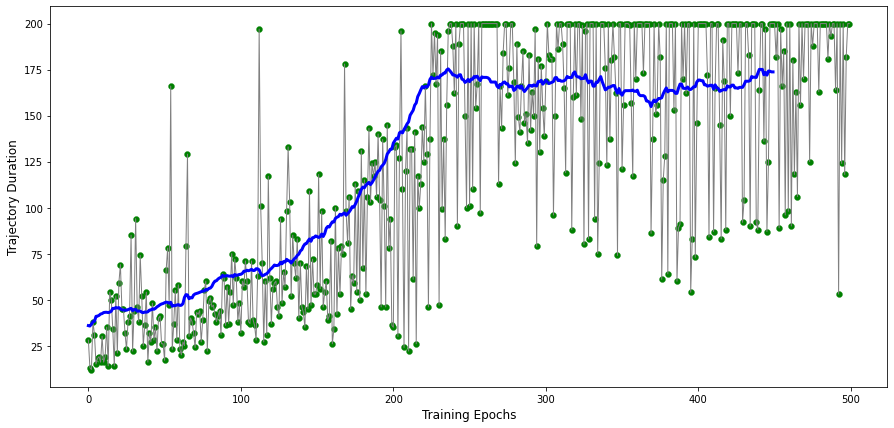

In [7]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

Debería poder obtener un gráfico con una tendencia agradablemente creciente de la duración de la trayectoria.

In [11]:
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.4 MB/s eta 0:00:00


Entorno de cartpole de renderizado

In [8]:
# Configuration the image rendering in colab

# Taken from 
# https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7

!apt-get install -y xvfb x11-utils &> /dev/null

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.* &> /dev/null

!pip install gym[box2d]==0.17.* &> /dev/null

# Taken from https://github.com/actions/virtual-environments/issues/214
!sudo apt-get update  &> /dev/null 
!sudo apt-get install xvfb --fix-missing &> /dev/null

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY # sanity checking: should be set to some value (e.g. 1005)

from IPython import display

:1001


También podemos representar cómo el Agente aplica la política con el siguiente código:

Reward: 94.0


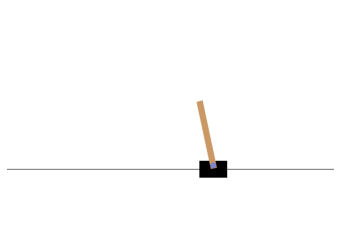

In [12]:
def watch_agent():
  env = gym.make('CartPole-v0')
  state = env.reset()
  rewards = []
  img = plt.imshow(env.render(mode='rgb_array'))
  for t in range(2000):
    pred = model(torch.from_numpy(state).float())
    action = np.random.choice(np.array([0,1]), p=pred.data.numpy())

    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        print("Reward:", sum([r for r in rewards]))
        break 
  env.close()

watch_agent()